# BigARTM 
---
Ответы на вопросы из задания, я поместил в самом конце тетради. Там я выделил три самые четкие топика и ответил на вопросы про параметры.


In [0]:
# Stop-words and punctuation for normalize function
from stop_words import get_stop_words
from string import punctuation

# Oper
import re
import gensim
import pickle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

import artm

# NLTK and pymorphy for normalize function 
from nltk import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from pymorphy2 import MorphAnalyzer

morph = MorphAnalyzer()

stemmer = LancasterStemmer()

punct = punctuation + '«»—…“”*№–'

stop_words = get_stop_words('russian')

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [14]:
!wget https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip

--2018-11-25 10:53:39--  https://github.com/mannefedov/compling_nlp_hse_course/raw/master/data/habr_texts.txt.zip
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/habr_texts.txt.zip [following]
--2018-11-25 10:53:40--  https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/data/habr_texts.txt.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18645068 (18M) [application/zip]
Saving to: ‘habr_texts.txt.zip’

habr_texts.txt.zip  100%[===================>]  17.78M  86.9MB/s    in 0.2s    

2018-11-25 10:53:40 (86.9 M

In [15]:
!unzip habr_texts.txt.zip

Archive:  habr_texts.txt.zip
  inflating: habr_texts.txt          


In [0]:
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

def normalize(text):
    
    words = [word.strip(punct) for word in remove_tags(text.lower()).split()]
    words = [morph.parse(word)[0] for word in words if word]
    words = [word for word in words if word not in get_stop_words('russian')]
    words = [word.normal_form for word in words if word.tag.POS == 'NOUN']
    words = [stemmer.stem(word) for word in words]
            
    return words

In [0]:
%%time
with open('habr_texts.txt') as file:
  data = file.read().splitlines()
    
texts = []
    
for text in data:
  texts.append(normalize(text))

In [35]:
%%time

ph = gensim.models.Phrases(data, scoring='npmi', threshold=0.4)
p = gensim.models.phrases.Phraser(ph)
ngrammed_texts = p[texts]

CPU times: user 1min 18s, sys: 28.8 ms, total: 1min 18s
Wall time: 1min 18s


In [0]:
with open('ngrammed_texts.pickle', 'wb') as f:
    pickle.dump(ngrammed_texts, f)

In [0]:
with open('ngrammed_texts.pickle', 'rb') as f:
    ngrammed_texts = pickle.load(f)

In [0]:
with open('habr_texts.vw', 'w') as file:
  for i, text in enumerate(ngrammed_texts):
    c = Counter(text)
    doc = 'doc_'+ str(i) + ' '
    vw_text = ' '.join([x.replace(':', '')+':'+str(c[x]) for x in c])
    file.write(doc + vw_text  + '\n')

In [0]:
def print_measures(model_artm):
    print('Sparsity Phi: {0:.3f} ARTM)'.format(
        model_artm.score_tracker['SparsityPhiScore'].last_value)
)
    print('Sparsity Theta: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['SparsityThetaScore'].last_value))

    print('Kernel contrast: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_contrast))

    print('Kernel purity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['TopicKernelScore'].last_average_purity))

    print('Perplexity: {0:.3f} (ARTM)'.format(
        model_artm.score_tracker['PerplexityScore'].last_value)
)
    plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
    plt.xlabel('Iterations count')
    plt.ylabel(' ARTM perp. (red)')
    plt.grid(True)
    plt.show()

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='habr_texts.vw',
                                        data_format='vowpal_wabbit',
                                        target_folder='batches',
                                        batch_size=2500)

In [0]:
batch_vectorizer = artm.BatchVectorizer(data_path='batches',
                                        data_format='batches')

In [0]:
dictionary = artm.Dictionary()

In [60]:
dictionary.gather(data_path='batches')
dictionary.filter(class_id='@default_class',
                  min_df=10, max_df=2000)

artm.Dictionary(name=dde7c1f1-b83c-4d7e-8fbb-9035860aaae8, num_entries=5595)

In [0]:
dictionary.save_text('dict.txt')

In [0]:
model_artm = artm.ARTM(topic_names=['topic_{}'.format(i) for i in range(600)],
                       
                       regularizers=[
                           artm.DecorrelatorPhiRegularizer(
                                            name='Decorr', tau=0.3, 
                                            class_ids=['@default_class'],
                                            topic_names=['topic_{}'.format(i) for i in range(0, 600)]),
                           
                           artm.SmoothSparsePhiRegularizer(
                                            name='SmoothPhi_1', 
                                            class_ids=['@default_class'],
                                            tau=0.05, 
                                            topic_names=['topic_{}'.format(i) for i in range(0, 600)])
                                    ]
                        )

In [0]:
model_artm.initialize(dictionary)

In [0]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                                    dictionary=dictionary))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore',
                                            probability_mass_threshold=0.1))
model_artm.scores.add(artm.TopTokensScore(class_id='@default_class',
                                          name='TopTokensScore_1', num_tokens=10))

In [0]:
model_artm.num_document_passes = 4
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=5)

Sparsity Phi: 0.000 ARTM)
Sparsity Theta: 0.000 (ARTM)
Kernel contrast: 0.047 (ARTM)
Kernel purity: 0.019 (ARTM)
Perplexity: 1184.416 (ARTM)


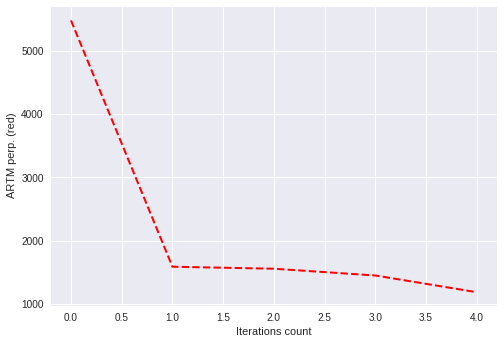

In [149]:
print_measures(model_artm)

In [0]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-0.1, 
                                                            topic_names=['topic_{}'.format(i) for i in range(1, 600)],
                                                            ))
model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name='SparseTheta', tau=-0.3, 
                                                              topic_names=['topic_{}'.format(i) for i in range(1, 600)]))

In [0]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=7)

In [0]:
phi_tau = model_artm.regularizers['SparsePhi'].tau
theta_tau = model_artm.regularizers['SparseTheta'].tau

for i in range(10):
    model_artm.regularizers['SparsePhi'].tau = (phi_tau + (phi_tau*2))
    model_artm.regularizers['SparseTheta'].tau = (theta_tau + (theta_tau*0.05))
    
    model_artm.fit_offline(batch_vectorizer=batch_vectorizer,num_collection_passes=1)

Sparsity Phi: 0.324 ARTM)
Sparsity Theta: 0.283 (ARTM)
Kernel contrast: 0.339 (ARTM)
Kernel purity: 0.498 (ARTM)
Perplexity: 309.863 (ARTM)


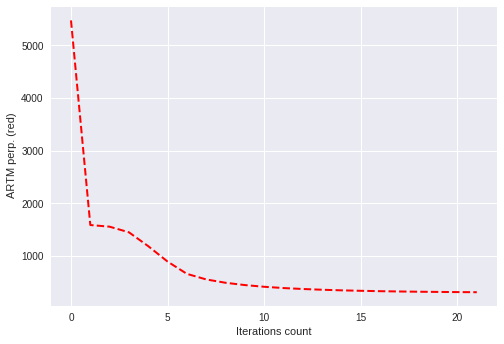

In [153]:
print_measures(model_artm)

In [154]:
for topic_name in model_artm.topic_names[:50]:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue

topic_0: 
атрибут
сохранение
имя
метаданные
сериализация
словарь
вычисление
умолчание
основа
способ
---------
topic_1: 
кабель
адаптер
розетка
аксессуар
провод
разъём
комплект
пара
устройство
зарядка
---------
topic_2: 
курс
лекция
занятие
основа
практика
преподаватель
структура
понятие
знакомство
введение
---------
topic_3: 
оценка
показатель
результат
методика
подразделение
вид
характеристика
эксперимент
проведение
наличие
---------
topic_4: 
задержка
прерывание
частота
порт
режим
мк
регистр
таймер
передача
часть
---------
topic_5: 
процесс
способ
вид
момент
имя
образ
количество
ряд
сторона
дело
---------
topic_6: 
контроллер
роль
внимание
фабрика
часть
действие
качество
образ
серия
название
---------
topic_7: 
кэш
кэширование
мейнтейнер
брокер
множество
линус
память
размер
статистика
момент
---------
topic_8: 
доклад
конференция
спикер
выступление
докладчик
тема
вопрос
организатор
день
уровень
---------
topic_9: 
программа
название
вид
часть
множество
начало
друг
история
способ
мера



---

# Подведем итоги

Я решил не чистить наш текст от самых частотных слов, однако сделал новую обработку текста с токенизацией и удалением стоп-слов из расширенного списка при помощи *stop_words*

Работая с  ARTM я в основном менял характеристики:



1.   Количество тем
2.   SparseTheta
3.   SparsePhi

Для выравнивания кривой, я повышал количество тем, понижал Phi и повышал 

**Топ 3 темы, которые мне понравились:**





In [160]:
for topic_name in ['topic_18', 'topic_1', 'topic_8']:
    print(topic_name + ': ')
    try:
        for x in model_artm.score_tracker['TopTokensScore_1'].last_tokens[topic_name]:
            print(x)
        print('---------')
    
    except KeyError:
        continue
  

topic_18: 
криптовалюта
регулирование
коммерция
законопроект
ассоциация
представитель
рф
поправка
отрасль
законодательство
---------
topic_1: 
кабель
адаптер
розетка
аксессуар
провод
разъём
комплект
пара
устройство
зарядка
---------
topic_8: 
доклад
конференция
спикер
выступление
докладчик
тема
вопрос
организатор
день
уровень
---------
